In [25]:
# loading packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import datetime
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.style as style
plt.style.use("markerr.mplstyle")

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import helper

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

#### getting list of different metros zips to split model if necessary 

In [2]:
# lists of relevent zipcodes
target_zips = pd.read_csv('target.csv', index_col = 0)
houston_zips_list = list(target_zips[target_zips['City']=='Houston']['zip_code'].unique())
paso_zips_list = list(target_zips[target_zips['City']=='El Paso']['zip_code'].unique())
san_zips_list = list(target_zips[target_zips['City']=='San Antonio']['zip_code'].unique())
austin_zips_list = list(target_zips[target_zips['City']=='Austin']['zip_code'].unique())
dallas_zips_list = list(target_zips[target_zips['City']=='Dallas-Fort Worth']['zip_code'].unique())


#### Loading and processing data to put into model

In [3]:
# load data
texas_data = pd.read_csv('merged_texas_data.csv', index_col = 0,
                   parse_dates = ['Time']
                  )

acs_data = pd.read_csv('merged_acs_data.csv', index_col = 0,
                      parse_dates = ['Time'])

zri = pd.read_csv('long_interpolated_target.csv', index_col = 0,
                   parse_dates=['Time']
                  )
#'new_feature'
# adding shift to zri
zri_shift = helper.time_lag_merge(zri, zri, {
    12:['zori_ssa',#'new_feature'
       ],
    13:['zori_ssa'],
    18:['zori_ssa'],
    24:['zori_ssa']
},
                                          return_full = True
                                         )

# there should now be extra values after our target. 
# We are gonna remove the missing values that happen at the start of our inputs tho
zri_shift = zri_shift.sort_values('Time')
zri_shift = zri_shift.dropna(subset = ['zori_ssa_24_month_shift'],axis='index',
                             how = 'any').reset_index(drop = True)
# Adding the shift values
zri_shift.loc[:,'zori_ssa_1_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_13_month_shift'])
zri_shift.loc[:,'zori_ssa_6_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_18_month_shift'])
zri_shift.loc[:,'zori_ssa_12_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_24_month_shift'])
zri_shift['zori_ssa_12_diff_lag_12_per'] = (zri_shift['zori_ssa_12_diff_lag_12']/
                                           zri_shift['zori_ssa_12_month_shift'])

zri_shift = zri_shift[['Time','zip_code','zori_ssa', #'new_feature'
                       'zori_ssa_12_month_shift',
                       'zori_ssa_1_diff_lag_12', 
                       'zori_ssa_6_diff_lag_12',
                       'zori_ssa_12_diff_lag_12_per'
                      ]]


# merge non acs data 
extra_shift = ['Gross Value Natural Gas Production', 'sap_case_shiller_index']
merged_df = helper.time_lag_merge(zri_shift, 
                                                    texas_data, {
    12:list(texas_data.drop(columns = ['Time','zip_code']+extra_shift
                            ).columns),
    13:extra_shift
},
                                          return_full = True
                                         )
# merge acs data
acs_1_cols = [
    'black_pop',
    'white_pop',
    'hispanic_pop',
    'high_school_diploma',
    'female_female_households',
    'armed_forces',
    'children',
    'black_pop_annual_pct_change',
    'white_pop_annual_pct_change',
    'hispanic_pop_annual_pct_change',
    'high_school_diploma_annual_pct_change',
    'children_annual_pct_change',
    ]
merged_df = helper.time_lag_merge(merged_df, 
                                                    acs_data, {
    36:list(acs_data.drop(columns = ['Time','zip_code'] + acs_1_cols).columns),
    48:acs_1_cols                                              
},
                                          return_full = True
                                         )
# # visualize missing values. it should be that acs 2 does not have a single zipcode
# # then removing that line and checking to see that there are no more missing values.
merged_df = merged_df.loc[merged_df['Time']>datetime.datetime(2016,6,2),:
                          ].reset_index(drop=True)
merged_df = merged_df.loc[merged_df['Time']<datetime.datetime(2022,7,2),:
                          ].reset_index(drop=True)
merged_df = merged_df.sort_values('Time')
merged_df = merged_df.dropna(subset = ['single_women_36_month_shift'],axis='index',
                             how = 'any').reset_index(drop = True)


#### Adding net approve feature.

In [4]:
merged_df['tx_net_approve_12_month_shift'] = (merged_df['tx_is_better_12_month_shift'] - 
                                              merged_df['tx_is_worse_12_month_shift'])


#### Features to put into model. Splitting test, train, forecast

In [5]:
# creating list of variables to put into the model. initialy is all non index and target
X_vals = [
    'zori_ssa_12_month_shift',
    'zori_ssa_1_diff_lag_12',
    'zori_ssa_6_diff_lag_12',
    'total_sales_tax_12_month_shift',
    'housing_units_over_50_units_36_month_shift',
    'housing_units_built_1960_to_1969_36_month_shift',
    'black_pop_48_month_shift',
    'zori_ssa_12_diff_lag_12_per',
    'children_annual_pct_change_48_month_shift',
    'female_40_to_44_annual_pct_change_36_month_shift',
    'housing_units_10_to_19_units_annual_pct_change_36_month_shift',
    'sales_tax_rate_annual_pct_change_12_month_shift',
    'female_female_households_48_month_shift',
    'women_with_associate_degree_annual_pct_change_36_month_shift',
    'average_household_size_owners_annual_pct_change_36_month_shift',
    'units_paying_cash_rent_annual_pct_change_36_month_shift',
    'quintile_1_upper_limit_annual_pct_change_36_month_shift',
    'Gross Value Natural Gas Production_13_month_shift',
    'women_with_doctoral_degree_annual_pct_change_36_month_shift',
    'total_sales_tax_annual_pct_change_12_month_shift',
    'housing_units_built_1940_to_1949_36_month_shift',
    'housing_units_built_1980_to_1989_annual_pct_change_36_month_shift',
    'female_35_to_39_annual_pct_change_36_month_shift',
    'bicycle_population_36_month_shift',
    'housing_units_20_to_49_units_annual_pct_change_36_month_shift',
    'taxpayer_count_12_month_shift',
    'housing_units_5_to_9_units_36_month_shift',
    'high_school_diploma_annual_pct_change_48_month_shift',
    'driving_alone_population_annual_pct_change_36_month_shift',
    'taxpayer_is_ratio_12_month_shift',
    'motorcycle_population_36_month_shift',
    'housing_units_single_family_attached_annual_pct_change_36_month_shift',
    'white_pop_annual_pct_change_48_month_shift',
    'taxpayer_cl_ratio_annual_pct_change_12_month_shift',
    'taxpayer_is_ratio_annual_pct_change_12_month_shift',
    'housing_units_built_1940_to_1949_annual_pct_change_36_month_shift',
    'black_pop_annual_pct_change_48_month_shift',
    'Gross Value Natural Gas Production_annual_pct_change_12_month_shift',
    'housing_units_single_family_attached_owned_36_month_shift',
    'single_women_annual_pct_change_36_month_shift',
    'housing_units_built_1930_to_1939_36_month_shift',
    'housing_units_built_1930_to_1939_annual_pct_change_36_month_shift',
    'female_25_to_29_annual_pct_change_36_month_shift',    
    'tx_net_approve_12_month_shift'
    
]
y_val = 'zori_ssa'

# split train and test based on a year in advance.
train = merged_df.loc[merged_df['Time']<datetime.datetime(2020,7,2),:].reset_index(drop=True)
post_train = merged_df.loc[merged_df['Time']>datetime.datetime(2020,7,2),:].reset_index(drop=True)
# test will have all zips. 
test = post_train.loc[post_train['Time']<datetime.datetime(2021,7,2),:].reset_index(drop=True)
forecast = post_train.loc[post_train['Time']>datetime.datetime(2021,7,2),:].reset_index(drop=True)

# set up x and y values with a scaler
# train first
scaler = StandardScaler(with_mean=False)
X = train[X_vals]
X = scaler.fit_transform(X)
y = train[y_val]
# test all
X_test = test[X_vals]
X_test = scaler.transform(X_test)
y_test = test[y_val]
# forecasted values
X_forecast = forecast[X_vals]
X_forecast = scaler.transform(X_forecast)


#### Construct model

In [6]:
lasso = Lasso(max_iter = 50000, random_state = 33)
alphas = [0.1,0.2,0.3, 0.6, 1]
tuned_parameters = [{'alpha': alphas}]
print(f'Performing Grid Search with alphas of: {alphas}')
clf = GridSearchCV(lasso, tuned_parameters, 
                    cv=5,n_jobs = -1, verbose=3,
                  scoring = 'neg_root_mean_squared_error')
# training on all non Houston zipcodes
clf.fit(X, y)

print(f"Best alpha {clf.best_params_['alpha']}")

Performing Grid Search with alphas of: [0.1, 0.2, 0.3, 0.6, 1]
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best alpha 0.1


#### Creating Coefficients of Model

In [7]:
coef_df = pd.DataFrame({'features':test[X_vals].columns,'coefs':clf.best_estimator_.coef_})
unselected_coef_df = coef_df[coef_df['coefs']==0]
coef_df = coef_df[coef_df['coefs']!=0]
coef_df['coefs_abs'] = abs(coef_df['coefs'])
coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True)
coef_df

,features,coefs,coefs_abs
0,zori_ssa_12_month_shift,237.244856,237.244856
1,zori_ssa_1_diff_lag_12,26.304015,26.304015
2,zori_ssa_6_diff_lag_12,-16.864855,16.864855
3,zori_ssa_12_diff_lag_12_per,4.323890,4.323890
4,total_sales_tax_12_month_shift,-4.170712,4.170712
5,housing_units_over_50_units_36_month_shift,-3.671122,3.671122
6,housing_units_built_1960_to_1969_36_month_shift,3.401850,3.401850
7,children_annual_pct_change_48_month_shift,-2.595727,2.595727
8,black_pop_48_month_shift,2.446128,2.446128
9,housing_units_single_family_attached_owned_36_...,-2.011038,2.011038


In [12]:
coef_df.loc[:,'sign'] = np.sign(coef_df.loc[:,'coefs'])

In [17]:
coef_df.loc[0:19,:].features.to_list()



['zori_ssa_12_month_shift',
 'zori_ssa_1_diff_lag_12',
 'zori_ssa_6_diff_lag_12',
 'zori_ssa_12_diff_lag_12_per',
 'total_sales_tax_12_month_shift',
 'housing_units_over_50_units_36_month_shift',
 'housing_units_built_1960_to_1969_36_month_shift',
 'children_annual_pct_change_48_month_shift',
 'black_pop_48_month_shift',
 'housing_units_single_family_attached_owned_36_month_shift',
 'Gross Value Natural Gas Production_13_month_shift',
 'female_40_to_44_annual_pct_change_36_month_shift',
 'sales_tax_rate_annual_pct_change_12_month_shift',
 'tx_net_approve_12_month_shift',
 'units_paying_cash_rent_annual_pct_change_36_month_shift',
 'housing_units_10_to_19_units_annual_pct_change_36_month_shift',
 'women_with_associate_degree_annual_pct_change_36_month_shift',
 'female_35_to_39_annual_pct_change_36_month_shift',
 'average_household_size_owners_annual_pct_change_36_month_shift',
 'quintile_1_upper_limit_annual_pct_change_36_month_shift']

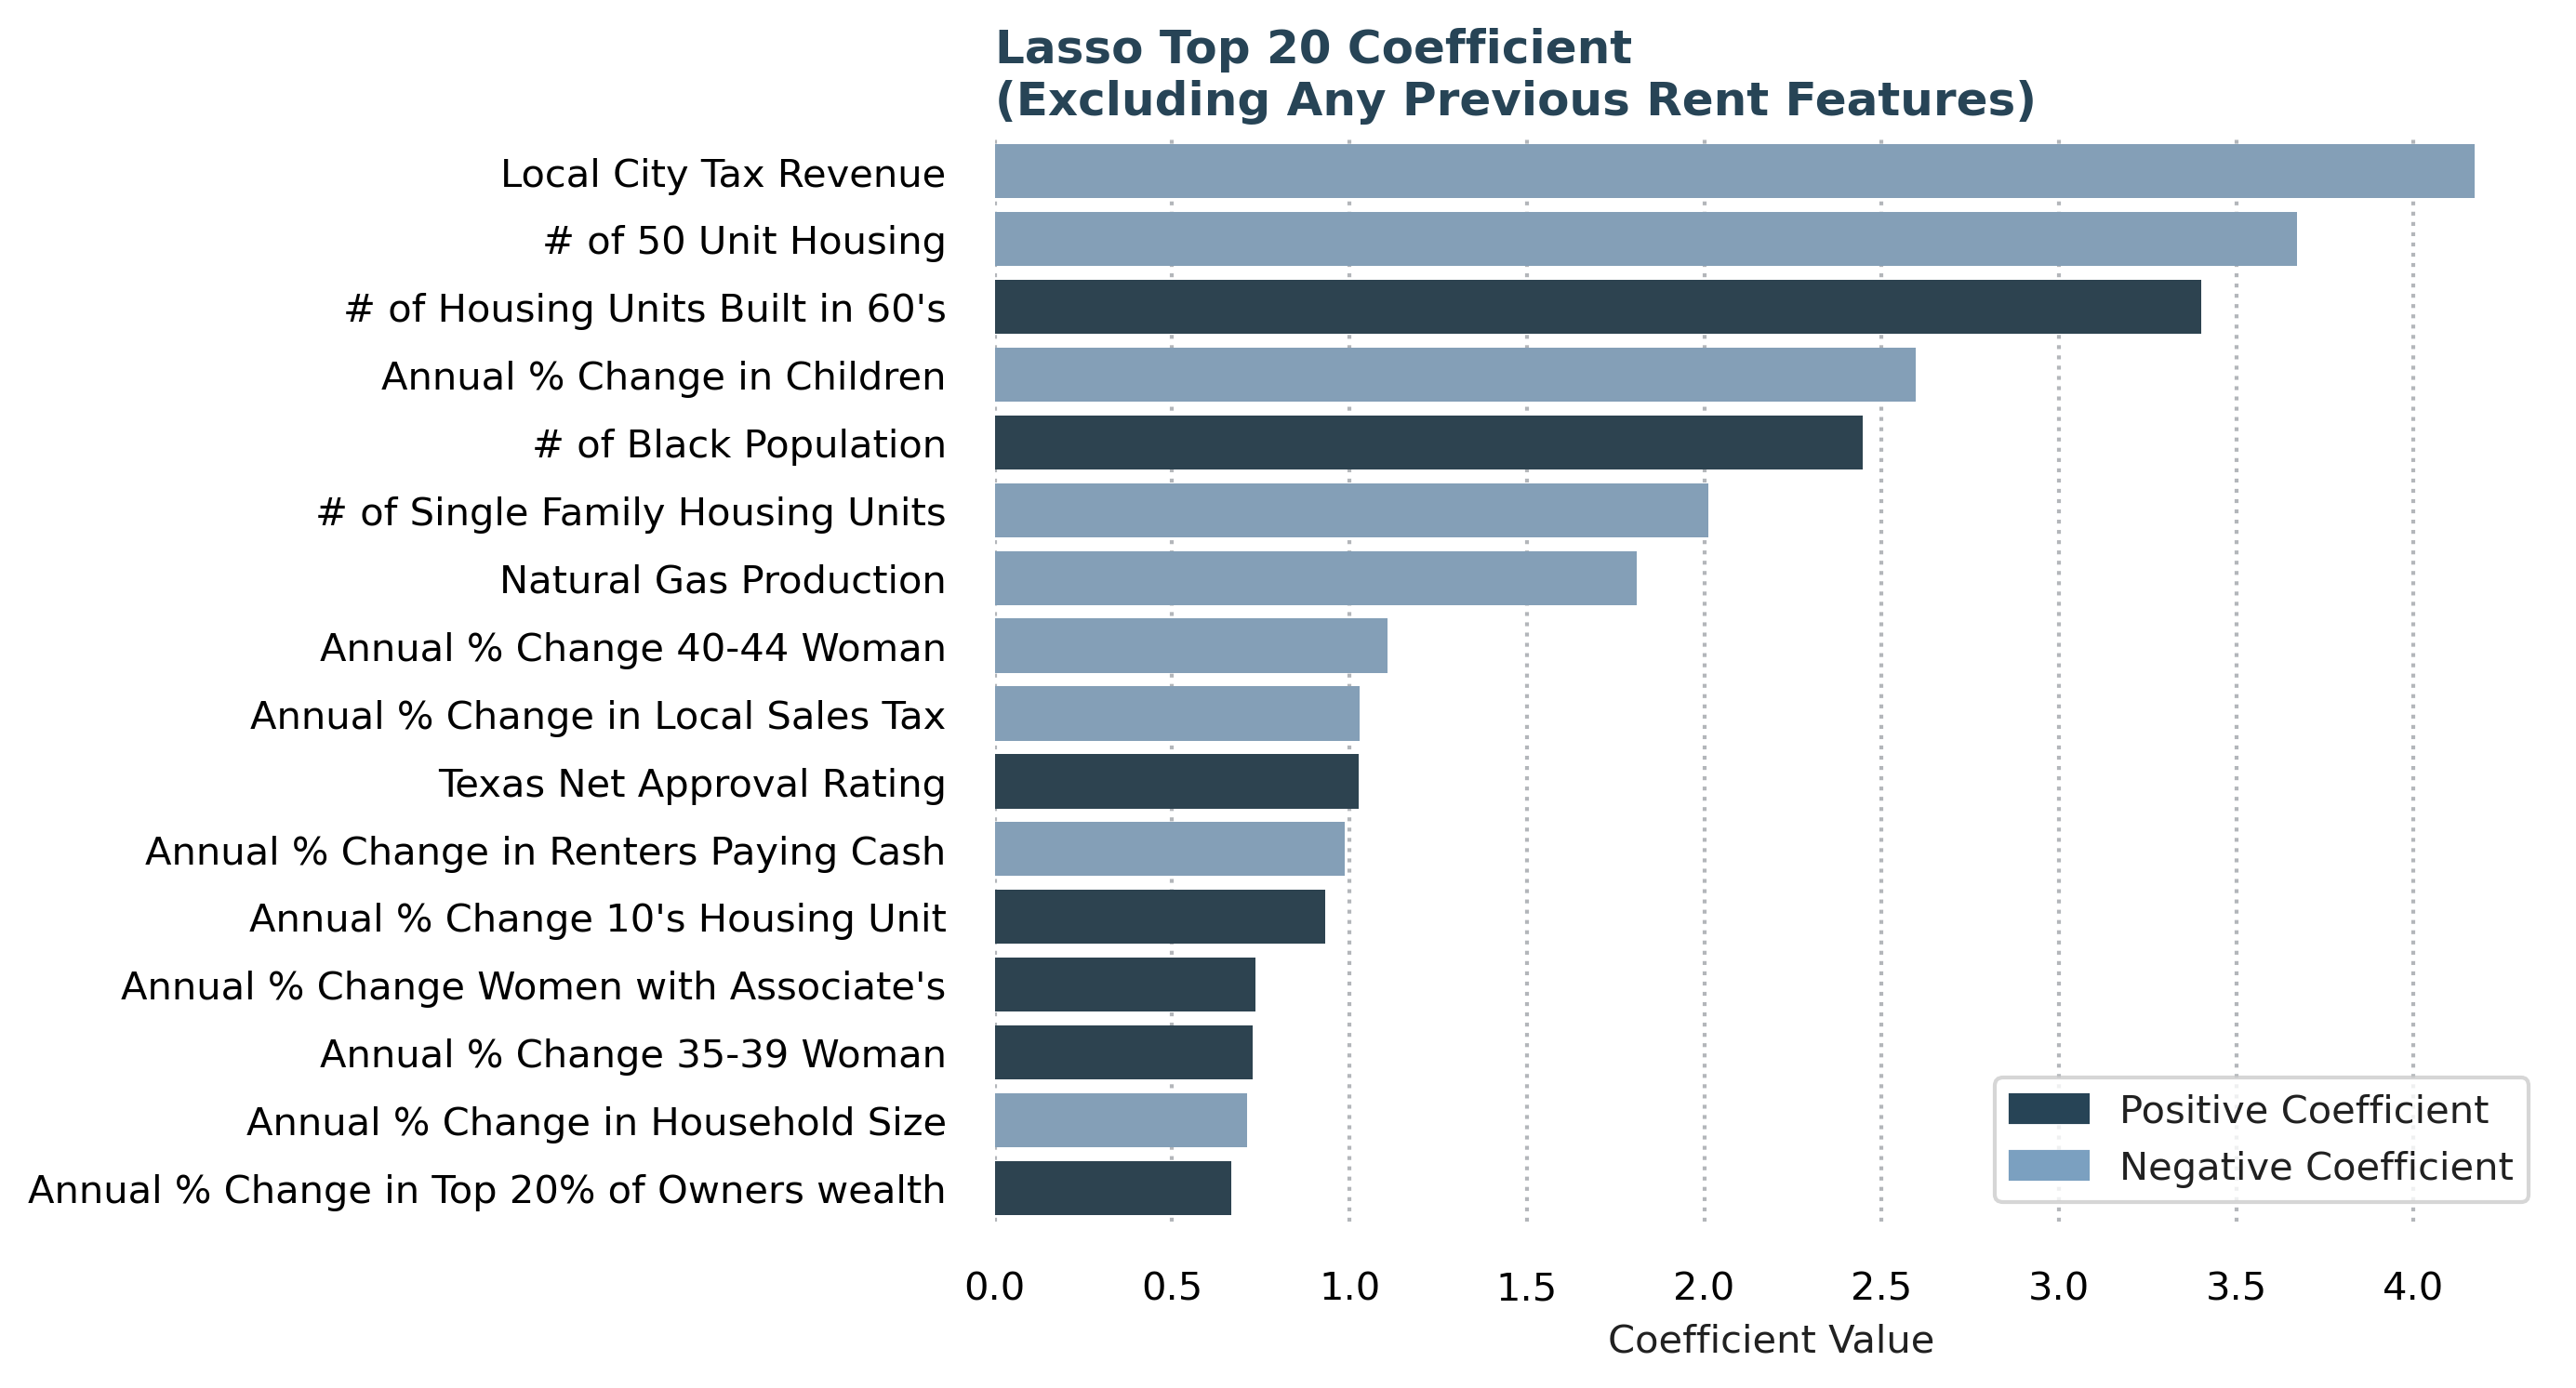

In [28]:
colors = ['#274456','#7BA0C0']
graph_df = coef_df.loc[4:19,:]
sign_=list(graph_df.sign)
color_map = {1:colors[0],-1:colors[1]}
sign_colors = map(color_map.get, sign_)
g = sns.barplot(data = graph_df,y='features',x='coefs_abs',palette=sign_colors)

pos_patch = mpatches.Patch(color=colors[0], label='Positive Coefficient')
neg_patch = mpatches.Patch(color=colors[1], label='Negative Coefficient')
plt.legend(handles=[pos_patch,neg_patch])

plt.title('Lasso Top 20 Coefficient\n(Excluding Any Previous Rent Features)')
plt.xlabel(r'Coefficient Value')
plt.ylabel('')

g.set_yticklabels(labels = 
[
#     'Rent',
#  '1 Month Change in Rent',
#  '6 Month Change in Rent',
#  'Annual % Change in Rent',
 'Local City Tax Revenue',
 '# of 50 Unit Housing',
 "# of Housing Units Built in 60's",
 'Annual % Change in Children',
 '# of Black Population',
 '# of Single Family Housing Units',
 'Natural Gas Production',
 'Annual % Change 40-44 Woman',
 'Annual % Change in Local Sales Tax',
 'Texas Net Approval Rating',
 'Annual % Change in Renters Paying Cash',
 "Annual % Change 10's Housing Unit",
 "Annual % Change Women with Associate's",
 'Annual % Change 35-39 Woman',
 'Annual % Change in Household Size',
 'Annual % Change in Top 20% of Owners wealth'])


plt.show()

In [ ]:
colors = ['#274456','#7BA0C0']
graph_df = coef_df.loc[0:19,:]
sign_=list(graph_df.sign)
color_map = {1:colors[0],-1:colors[1]}
sign_colors = map(color_map.get, sign_)
g = sns.barplot(data = graph_df,y='features',x='coefs_abs',palette=sign_colors)

pos_patch = mpatches.Patch(color=colors[0], label='Positive Coefficient')
neg_patch = mpatches.Patch(color=colors[1], label='Negative Coefficient')
plt.legend(handles=[pos_patch,neg_patch])

plt.title('Lasso Top 20 Coefficient')
plt.xlabel(r'Coefficient Value')
plt.ylabel('')

# g.set_yticklabels(labels = [
#     r'Above Ground $ft^{2}$ $\sqrt{~~}$',
#     r'Years Since Built $\sqrt{~~}$',
#     r'Total $ft^{2}$ $\sqrt{~~}$',
#     r'Overall Score $\sqrt{~~}$',
#     r'Lot Area $\sqrt{~~}$',
#     'Total High Quality $ft^{2}$',
#     r'Overall Quality$^{3}$',
#     'Neighborhood Comp',
#     r'Basement Exposure$^{3}$',
#     'Garage Cars',
#     'Crawford Neighborhood',
#     r'Kitchen Qualilty$^{3}$',
#     'Garage Area',
#     'MSZoning Comp',
#     'Year Remodel Added',
#     'Brick Face Exterior1st',
#     'Typical Functionality',
#     'Condition1 Normal',
#     '1 Story-1945 & Older',
#     'Brookside Neighborhood'
# ])


plt.show()

####  testing all zipcodes on the model

In [8]:
y_pred_test = clf.predict(X_test)

test.loc[:,'pred'] = y_pred_test
test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_pred_test

rms = mean_squared_error(y_test, y_pred_test, squared=False)
rms


53.56478327318194

####  Feeding forecast values into model

In [9]:
y_pred_fore = clf.predict(X_forecast)
forecast.loc[:,'pred'] = y_pred_fore


#### Construct timeline of zori and what prediciton status they are.

In [10]:
# put actual data into correct format
zori_pred_act = zri[['Time','zip_code','zori_ssa']].dropna(subset=['zori_ssa'])
zori_pred_act['model_code'] = 'actual_values'
# put train into correct format
zori_pred_train = test[['Time','zip_code','pred']]
zori_pred_train.columns = ['Time','zip_code','zori_ssa']
zori_pred_train['model_code'] = 'lasso_base'# just code for the lasso model
# put forecast into correct format
zori_pred_fore = forecast[['Time','zip_code','pred']]
zori_pred_fore.columns = ['Time','zip_code','zori_ssa']
zori_pred_fore['model_code'] = 'lasso_base'
# concat them together
zori_pred = pd.concat([zori_pred_act, zori_pred_train, 
                       zori_pred_fore]).reset_index(drop=True)

zori_pred.to_csv('zori_pred_lasso_base.csv')

<ipython-input-10-9d07dc34fbe8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zori_pred_train['model_code'] = 'lasso_base'# just code for the lasso model
<ipython-input-10-9d07dc34fbe8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zori_pred_fore['model_code'] = 'lasso_base'
